In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression, QuantileRegressor
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import seaborn as sns
import scienceplots
from scipy import stats
import os


In [9]:

df = pd.read_csv('data/price_reduction_models.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

# Function to find and analyze duplicate rows
# def find_duplicates(df, subset=None, save_to_csv=False, output_file='duplicates.csv'):
#     """
#     Find duplicate rows in a DataFrame based on all columns (or specified subset).
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         Input DataFrame to check for duplicates
#     subset : list, optional
#         List of column names to check for duplicates. If None, uses all columns.
#     save_to_csv : bool
#         If True, save duplicate rows to a CSV file
#     output_file : str
#         Name of output CSV file if save_to_csv is True
    
#     Returns:
#     --------
#     pd.DataFrame : DataFrame containing all duplicate rows
#     """
#     # Find all duplicate rows (keep=False marks all occurrences)
#     if subset is None:
#         duplicates = df[df.duplicated(keep=False)]
#     else:
#         duplicates = df[df.duplicated(subset=subset, keep=False)]
    
#     print(f"Total rows in dataset: {len(df)}")
#     print(f"Duplicate rows found: {len(duplicates)}")
#     print(f"Unique duplicate groups: {len(duplicates.drop_duplicates())}")
    
#     if len(duplicates) > 0:
#         print(f"\nFirst duplicate rows:")
#         print(duplicates.head(20))
        
#         if save_to_csv:
#             duplicates.to_csv(output_file, index=False)
#             print(f"\nDuplicate rows saved to: {output_file}")
#     else:
#         print("\nNo duplicate rows found!")
    
#     return duplicates

# # Example usage:
# # duplicates = find_duplicates(df)
# # duplicates = find_duplicates(df, subset=['Model', 'Release Date'])  # Check specific columns
# # duplicates = find_duplicates(df, save_to_csv=True, output_file='my_duplicates.csv')

# #print the first 5 rows of the datafr

Index(['Model', 'Model Slug', 'Creator', 'License', 'Context\r\n Window',
       'Access Date on AA', 'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       ...
       'arc_match_score', 'arc_matched', 'Training_Compute_FLOP',
       'training_compute_matched_model', 'training_compute_match_score',
       'training_compute_matched', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Benchmark Cost USD',
       'Blended Price (3:1) USD/1M Tokens'],
      dtype='object', length=112)


MMLU 20-40% R² = 0.853
MMLU 40-60% R² = 0.933
MMLU 60-80% R² = 0.976
Figure saved to: figures/gpqa_open_license_bucket.png


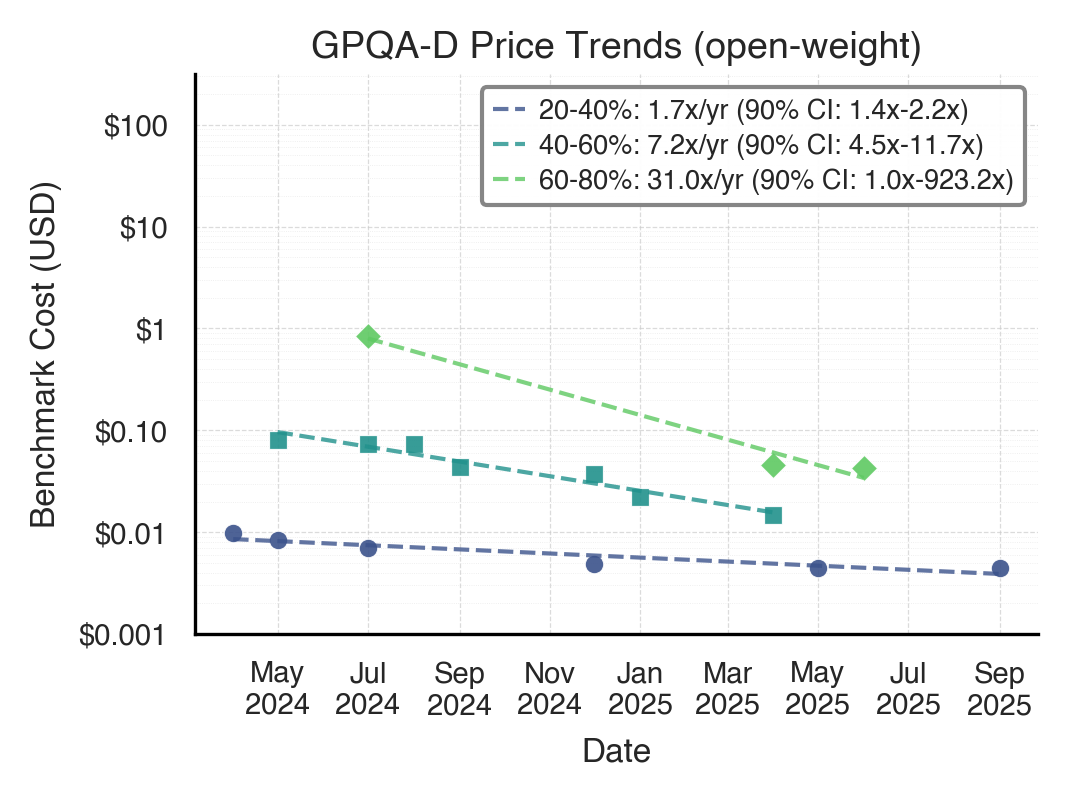

In [10]:

# --- Plot function with daily/monthly min fix ---
def plot_combined_record_small_trends(
    df,
    open_license_only=False,
    price_col='Lowest Blended Price AA',
    show_model_names=False,
    min_date=datetime(2023, 1, 1),
    confidence_interval=True,
    include_chinese=None,
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    mmlu_ranges=[(30, 50), (50, 70), (70, 90)],
    include_reasoning_models=True,
    date_granularity='day',  # 'day' (default) aggregates to daily min; use 'month' to aggregate to monthly min
    save_path=None,  # Optional path to save the figure (e.g., "figures/bucket_figure.png")
    icml_format=True  # If True, use ICML dual-column formatting
):
    """
    Plot record-small points and their trend lines for specified MMLU ranges on a single graph.
    The running-min is computed AFTER collapsing to the minimum price per date (or per month).

    Parameters:
      df: DataFrame containing the model data
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data
      show_model_names: If True, displays model names next to record-small points
      min_date: Only include models released on or after this date (datetime or string)
      confidence_interval: If True, displays 90% confidence intervals for trend lines
      include_chinese: True => only Chinese models; False => exclude Chinese; None => all
      benchmark_col: Column name for the benchmark to use
      mmlu_ranges: List of tuples defining MMLU score ranges
      include_reasoning_models: If False, exclude reasoning models
      date_granularity: 'day' or 'month' — determines how we aggregate before cummin()
      save_path: Optional path to save the figure (e.g., "figures/bucket_figure.png"). If None, figure is only displayed.
      icml_format: If True, use ICML dual-column formatting (3.25" width)
    """
    # Set up styling based on format
    import seaborn as sns
    sns.set_style("white")
    
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.linewidth': 0.8,
        'axes.labelpad': 4,
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
    })
    
    if icml_format:
        # ICML single column width: 3.25", double column: 6.75"
        fig, ax = plt.subplots(figsize=(3.5, 2.6), dpi=300)
        TITLE_SIZE = 9
        LABEL_SIZE = 8
        TICK_SIZE = 7
        MARKER_SIZE = 20
        LINE_WIDTH = 1.0
        ANNOTATION_SIZE = 5
        EDGE_WIDTH = 0.3
        # --- LEGEND CONFIGURATION (adjust these for ICML) ---
        LEGEND_SIZE = 6.5          # Font size for legend text
        LEGEND_LOC = 'upper right' # Location: 'upper right', 'upper left', 'lower right', 'lower left', 'best'
        LEGEND_BORDERPAD = 0.4     # Padding inside legend box
        LEGEND_HANDLELENGTH = 1.2  # Length of legend line/marker
        LEGEND_HANDLETEXTPAD = 0.5 # Spacing between handle and text
        LEGEND_LABELSPACING = 0.3  # Vertical spacing between legend entries
        LEGEND_FRAMEALPHA = 0.95   # Transparency of legend background
        LEGEND_BBOX = None         # Set to (x, y) tuple to position legend manually, e.g., (1.02, 1.0)
    else:
        fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
        TITLE_SIZE = 18
        LABEL_SIZE = 18
        TICK_SIZE = 17
        MARKER_SIZE = 100
        LINE_WIDTH = 2.5
        ANNOTATION_SIZE = 9
        EDGE_WIDTH = 0.5
        # --- LEGEND CONFIGURATION (non-ICML) ---
        LEGEND_SIZE = 17
        LEGEND_LOC = 'upper right'
        LEGEND_BORDERPAD = 1
        LEGEND_HANDLELENGTH = 2
        LEGEND_HANDLETEXTPAD = 0.8
        LEGEND_LABELSPACING = 0.5
        LEGEND_FRAMEALPHA = 0.95
        LEGEND_BBOX = None
    
    fig.patch.set_facecolor('white'); ax.set_facecolor('white')

    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

    mmlu_col = benchmark_col
    license_col = 'License'
    chinese_col = 'Chinese'
    reasoning_col = 'Reasoning_TF'

    all_dates = []
    all_prices = []

    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i % len(markers)]

        # Work on a copy
        df_work = df.copy()

        # MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                              .str.replace('%','',regex=False)
                              .astype(float)
        )

        # Price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                              .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # Filter: open license
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]

        # Filter: min_date
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]

        # Filter: Chinese
        if include_chinese is not None:
            if include_chinese:
                df_work = df_work[df_work[chinese_col] == True]
            else:
                df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]

        # Filter: Reasoning models
        if not include_reasoning_models:
            df_work = df_work[(df_work[reasoning_col] != True) | (df_work[reasoning_col].isna())]

        # Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # Drop missing Release Date / price, remove non-positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        if len(df_sub) == 0:
            continue

        # ---- FIX: aggregate to daily/monthly minimum BEFORE running cummin ----
        df_sub = df_sub.sort_values(['Release Date', price_col]).copy()

        if date_granularity.lower().startswith('m'):
            # Monthly min: use month start timestamps for x-axis consistency
            df_sub['DateKey'] = df_sub['Release Date'].dt.to_period('M').dt.to_timestamp()
        else:
            # Daily min (default)
            df_sub['DateKey'] = df_sub['Release Date'].dt.normalize()

        # Keep the actual row that has the min price on each DateKey (so labels remain correct)
        idx_min_per_date = df_sub.groupby('DateKey')[price_col].idxmin()
        df_by_date = df_sub.loc[idx_min_per_date].sort_values('DateKey').copy()

        # Ordinal for regression
        df_by_date['Date_Ordinal'] = df_by_date['DateKey'].map(datetime.toordinal)

        # Running minima across the already-collapsed series
        df_by_date['Is_Record_Small'] = df_by_date[price_col].cummin() == df_by_date[price_col]
        record_small = df_by_date[df_by_date['Is_Record_Small']].copy()

        if len(record_small) == 0:
            continue

        # Regression on log10(price) vs ordinal date
        X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)

        # R²
        r_squared = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")

        # Prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

        # Annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365

        # 90% CI on slope (if enough points)
        n = len(X_rec)
        ci_label = ""
        ci_lower = None
        ci_upper = None
        if confidence_interval and n > 2:
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))

            t_val = stats.t.ppf(0.95, n - 2)
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se

            # Check if CI values would cause overflow before computing annual factors
            # If ci_upper or ci_lower are very negative (< -50), the annual factors become extremely large
            if ci_upper > -50 and ci_lower > -50:
                try:
                    annual_factor_lower = 1 / (10**ci_upper)**365
                    annual_factor_upper = 1 / (10**ci_lower)**365
                    # Check if values are finite and reasonable
                    if np.isfinite(annual_factor_lower) and np.isfinite(annual_factor_upper):
                        ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"
                except (OverflowError, RuntimeWarning):
                    # Skip CI label if overflow occurs
                    pass

        # Scatter of record-small points
        sns.scatterplot(
            x=record_small['DateKey'],
            y=record_small[price_col],
            color=color,
            s=MARKER_SIZE,
            marker=marker,
            alpha=0.9,
            edgecolor='white',
            linewidth=EDGE_WIDTH,
            ax=ax
        )

        # Trend line
        benchmark_name = benchmark_col.split(" ")[0]
        if benchmark_name == 'epoch_gpqa':
            benchmark_name = 'GPQA-D'

        # Format label based on ICML format (always include 90% CI)
        if icml_format:
            label_text = f'{min_mmlu}-{max_mmlu}%: {annual_factor_rec:.1f}x/yr{ci_label}'
        else:
            label_text = f'{benchmark_name} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'

        ax.plot(
            x_dates,
            10**y_rec_log_pred,
            color=color,
            linestyle='--',
            linewidth=LINE_WIDTH,
            alpha=0.8,
            label=label_text
        )

        # Confidence band
        if confidence_interval and n > 2 and ci_lower is not None and ci_upper is not None:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            # Check if values would cause overflow before plotting
            # If y_upper > 100 or y_lower < -100, skip plotting confidence band
            if np.max(y_upper) <= 100 and np.min(y_lower) >= -100:
                try:
                    y_lower_linear = 10**y_lower
                    y_upper_linear = 10**y_upper
                    # Check if values are finite
                    if np.all(np.isfinite(y_lower_linear)) and np.all(np.isfinite(y_upper_linear)):
                        ax.fill_between(
                            x_dates,
                            y_lower_linear,
                            y_upper_linear,
                            color=color,
                            alpha=0.1
                        )
                except (OverflowError, RuntimeWarning):
                    # Skip confidence band if overflow occurs
                    pass

        # Model labels
        if show_model_names:
            for _, row in record_small.iterrows():
                ax.annotate(
                    row['Model'],
                    (row['DateKey'], row[price_col]),
                    xytext=(3 if icml_format else 5, 3 if icml_format else 5),
                    textcoords='offset points',
                    fontsize=ANNOTATION_SIZE,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )

        all_dates.extend(record_small['DateKey'].tolist())
        all_prices.extend(record_small[price_col].tolist())

    # Axes / formatting
    ax.set_yscale('log')
    
    # Custom y-axis formatter to display dollar amounts instead of scientific notation
    from matplotlib.ticker import FuncFormatter
    
    def dollar_formatter(x, pos):
        """Format y-axis values as dollar amounts"""
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"
    
    ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    
    ax.set_xlabel('Date', fontsize=LABEL_SIZE)
    ax.set_ylabel('Benchmark Cost (USD)', fontsize=LABEL_SIZE)

    date_formatter = DateFormatter('%b %Y') if not icml_format else DateFormatter('%b\n%Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=0 if icml_format else 45)

    lic_label = 'open-weight' if open_license_only else 'all'
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    chinese_filter = " (Chinese)" if include_chinese is True else " (non-Chinese)" if include_chinese is False else ""
    reasoning_filter = " (non-reasoning)" if not include_reasoning_models else ""
    benchmark_name = benchmark_col.split(" ")[0]
    
    if icml_format:
        ax.set_title(
            f'GPQA-D Price Trends ({lic_label})',
            fontsize=TITLE_SIZE, pad=4
        )
    else:
        ax.set_title(
            f'Lowest Available Price Trends by Epoch GPQA-D Range ({lic_label}){date_filter}{chinese_filter}{reasoning_filter}',
            fontsize=TITLE_SIZE, pad=15
        )

    ax.grid(True, which='major', linestyle='--', linewidth=0.3 if icml_format else 0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.2 if icml_format else 0.5, alpha=0.4)

    legend_kwargs = dict(
        loc=LEGEND_LOC,
        fontsize=LEGEND_SIZE,
        frameon=True,
        fancybox=True,
        framealpha=LEGEND_FRAMEALPHA,
        edgecolor='gray',
        borderpad=LEGEND_BORDERPAD,
        handlelength=LEGEND_HANDLELENGTH,
        handletextpad=LEGEND_HANDLETEXTPAD,
        labelspacing=LEGEND_LABELSPACING
    )
    # Add bbox_to_anchor if specified for manual positioning
    if LEGEND_BBOX is not None:
        legend_kwargs['bbox_to_anchor'] = LEGEND_BBOX
    legend = ax.legend(**legend_kwargs)

    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE, width=0.8, length=3)

    # Spines - only left and bottom (matching frontier_price.ipynb style)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

    # Set y-axis limits BEFORE tight_layout() so matplotlib knows valid range
    plt.ylim(10**-3, 10**2.5)
    
    plt.tight_layout(pad=0.5 if icml_format else 1.08)
    
    # Save figure if save_path is provided
    if save_path is not None:
        # Ensure directory exists
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
            print(f"Created directory: {output_dir}")
        
        # Save the figure
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")
    
    plt.show()


# --- Usage example (matches your last call) ---
# Daily min (default):
plot_combined_record_small_trends(
    df,
    open_license_only=True,
    price_col="Benchmark Cost USD",
    confidence_interval=True,
    min_date=datetime(2024, 4, 1),
    benchmark_col='epoch_gpqa',
    show_model_names=False,
    include_reasoning_models=True,
    mmlu_ranges=[(20, 40), (40, 60), (60, 80)],
    date_granularity='day',  # change to 'month' to aggregate monthly before cummin
    save_path="figures/gpqa_open_license_bucket.png",  # Descriptive filename based on benchmark and license type
    icml_format=True  # Set to True for ICML dual-column format
)


## Old Style


In [ ]:

# # --- Plot function with daily/monthly min fix ---
# def plot_combined_record_small_trends(
#     df,
#     open_license_only=False,
#     price_col='Lowest Blended Price AA',
#     show_model_names=False,
#     min_date=datetime(2023, 1, 1),
#     confidence_interval=True,
#     include_chinese=None,
#     benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
#     mmlu_ranges=[(30, 50), (50, 70), (70, 90)],
#     include_reasoning_models=True,
#     date_granularity='day',  # 'day' (default) aggregates to daily min; use 'month' to aggregate to monthly min
#     save_path=None  # Optional path to save the figure (e.g., "figures/bucket_figure.png")
# ):
#     """
#     Plot record-small points and their trend lines for specified MMLU ranges on a single graph.
#     The running-min is computed AFTER collapsing to the minimum price per date (or per month).

#     Parameters:
#       df: DataFrame containing the model data
#       open_license_only: If True, only include models with open licenses
#       price_col: Column name for price data
#       show_model_names: If True, displays model names next to record-small points
#       min_date: Only include models released on or after this date (datetime or string)
#       confidence_interval: If True, displays 90% confidence intervals for trend lines
#       include_chinese: True => only Chinese models; False => exclude Chinese; None => all
#       benchmark_col: Column name for the benchmark to use
#       mmlu_ranges: List of tuples defining MMLU score ranges
#       include_reasoning_models: If False, exclude reasoning models
#       date_granularity: 'day' or 'month' — determines how we aggregate before cummin()
#       save_path: Optional path to save the figure (e.g., "figures/bucket_figure.png"). If None, figure is only displayed.
#     """
#     # Set up styling
#     plt.rcParams['font.family'] = 'sans-serif'
#     fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
#     fig.patch.set_facecolor('white'); ax.set_facecolor('white')

#     palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
#     markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

#     mmlu_col = benchmark_col
#     license_col = 'License'
#     chinese_col = 'Chinese'
#     reasoning_col = 'Reasoning_TF'

#     all_dates = []
#     all_prices = []

#     for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
#         color = palette[i]
#         marker = markers[i % len(markers)]

#         # Work on a copy
#         df_work = df.copy()

#         # MMLU "XX%" → float
#         df_work[mmlu_col] = (
#             df_work[mmlu_col].astype(str)
#                               .str.replace('%','',regex=False)
#                               .astype(float)
#         )

#         # Price "$X,XXX" → float
#         df_work[price_col] = (
#             df_work[price_col].astype(str)
#                               .str.replace('[$,]','',regex=True)
#         )
#         df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

#         # Filter: open license
#         if open_license_only:
#             df_work = df_work[
#                 df_work[license_col].notna() &
#                 df_work[license_col].str.contains('open', case=False, na=False)
#             ]

#         # Filter: min_date
#         if min_date is not None:
#             if isinstance(min_date, str):
#                 min_date = pd.to_datetime(min_date)
#             df_work = df_work[df_work['Release Date'] >= min_date]

#         # Filter: Chinese
#         if include_chinese is not None:
#             if include_chinese:
#                 df_work = df_work[df_work[chinese_col] == True]
#             else:
#                 df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]

#         # Filter: Reasoning models
#         if not include_reasoning_models:
#             df_work = df_work[(df_work[reasoning_col] != True) | (df_work[reasoning_col].isna())]

#         # Filter to MMLU range
#         df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

#         # Drop missing Release Date / price, remove non-positive prices
#         df_sub = df_sub.dropna(subset=['Release Date', price_col])
#         df_sub = df_sub[df_sub[price_col] > 0]

#         if len(df_sub) == 0:
#             continue

#         # ---- FIX: aggregate to daily/monthly minimum BEFORE running cummin ----
#         df_sub = df_sub.sort_values(['Release Date', price_col]).copy()

#         if date_granularity.lower().startswith('m'):
#             # Monthly min: use month start timestamps for x-axis consistency
#             df_sub['DateKey'] = df_sub['Release Date'].dt.to_period('M').dt.to_timestamp()
#         else:
#             # Daily min (default)
#             df_sub['DateKey'] = df_sub['Release Date'].dt.normalize()

#         # Keep the actual row that has the min price on each DateKey (so labels remain correct)
#         idx_min_per_date = df_sub.groupby('DateKey')[price_col].idxmin()
#         df_by_date = df_sub.loc[idx_min_per_date].sort_values('DateKey').copy()

#         # Ordinal for regression
#         df_by_date['Date_Ordinal'] = df_by_date['DateKey'].map(datetime.toordinal)

#         # Running minima across the already-collapsed series
#         df_by_date['Is_Record_Small'] = df_by_date[price_col].cummin() == df_by_date[price_col]
#         record_small = df_by_date[df_by_date['Is_Record_Small']].copy()

#         if len(record_small) == 0:
#             continue

#         # Regression on log10(price) vs ordinal date
#         X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
#         y_rec_log = np.log10(record_small[price_col].values)
#         rec_ols = LinearRegression().fit(X_rec, y_rec_log)

#         # R²
#         r_squared = rec_ols.score(X_rec, y_rec_log)
#         print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")

#         # Prediction line
#         min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
#         x_range = np.arange(min_ord, max_ord + 1)
#         x_dates = [datetime.fromordinal(int(d)) for d in x_range]
#         y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))

#         # Annual decrease rate
#         annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
#         annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365

#         # 90% CI on slope (if enough points)
#         n = len(X_rec)
#         ci_label = ""
#         ci_lower = None
#         ci_upper = None
#         if confidence_interval and n > 2:
#             y_pred = rec_ols.predict(X_rec)
#             residuals = y_rec_log - y_pred
#             mse = np.sum(residuals**2) / (n - 2)
#             se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))

#             t_val = stats.t.ppf(0.95, n - 2)
#             ci_lower = rec_ols.coef_[0] - t_val * se
#             ci_upper = rec_ols.coef_[0] + t_val * se

#             # Check if CI values would cause overflow before computing annual factors
#             # If ci_upper or ci_lower are very negative (< -50), the annual factors become extremely large
#             if ci_upper > -50 and ci_lower > -50:
#                 try:
#                     annual_factor_lower = 1 / (10**ci_upper)**365
#                     annual_factor_upper = 1 / (10**ci_lower)**365
#                     # Check if values are finite and reasonable
#                     if np.isfinite(annual_factor_lower) and np.isfinite(annual_factor_upper):
#                         ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"
#                 except (OverflowError, RuntimeWarning):
#                     # Skip CI label if overflow occurs
#                     pass

#         # Scatter of record-small points
#         sns.scatterplot(
#             x=record_small['DateKey'],
#             y=record_small[price_col],
#             color=color,
#             s=100,
#             marker=marker,
#             alpha=0.9,
#             edgecolor='white',
#             linewidth=0.5,
#             ax=ax
#         )

#         # Trend line
#         benchmark_name = benchmark_col.split(" ")[0]
#         if benchmark_name == 'epoch_gpqa':
#             benchmark_name = 'GPQA-D'

#         ax.plot(
#             x_dates,
#             10**y_rec_log_pred,
#             color=color,
#             linestyle='--',
#             linewidth=2.5,
#             alpha=0.8,
#             label=f'{benchmark_name} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
#         )

#         # Confidence band
#         if confidence_interval and n > 2 and ci_lower is not None and ci_upper is not None:
#             y_lower = ci_lower * x_range + rec_ols.intercept_
#             y_upper = ci_upper * x_range + rec_ols.intercept_
            
#             # Check if values would cause overflow before plotting
#             # If y_upper > 100 or y_lower < -100, skip plotting confidence band
#             if np.max(y_upper) <= 100 and np.min(y_lower) >= -100:
#                 try:
#                     y_lower_linear = 10**y_lower
#                     y_upper_linear = 10**y_upper
#                     # Check if values are finite
#                     if np.all(np.isfinite(y_lower_linear)) and np.all(np.isfinite(y_upper_linear)):
#                         ax.fill_between(
#                             x_dates,
#                             y_lower_linear,
#                             y_upper_linear,
#                             color=color,
#                             alpha=0.1
#                         )
#                 except (OverflowError, RuntimeWarning):
#                     # Skip confidence band if overflow occurs
#                     pass

#         # Model labels
#         if show_model_names:
#             for _, row in record_small.iterrows():
#                 ax.annotate(
#                     row['Model'],
#                     (row['DateKey'], row[price_col]),
#                     xytext=(5, 5),
#                     textcoords='offset points',
#                     fontsize=9,
#                     color=color,
#                     fontweight='bold',
#                     alpha=0.9
#                 )

#         all_dates.extend(record_small['DateKey'].tolist())
#         all_prices.extend(record_small[price_col].tolist())

#     # Axes / formatting
#     ax.set_yscale('log')
    
#     # Custom y-axis formatter to display dollar amounts instead of scientific notation
#     from matplotlib.ticker import FuncFormatter
    
#     def dollar_formatter(x, pos):
#         """Format y-axis values as dollar amounts"""
#         if x >= 1:
#             return f"${x:.0f}"
#         elif x >= 0.01:
#             return f"${x:.2f}"
#         elif x >= 0.001:
#             return f"${x:.3f}"
#         else:
#             return f"${x:.4f}"
    
#     ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    
#     ax.set_xlabel('Date', fontsize=18, fontweight='bold')
#     ax.set_ylabel('Benchmark Cost GPQA-D (USD)', fontsize=18, fontweight='bold')

#     date_formatter = DateFormatter('%b %Y')
#     ax.xaxis.set_major_formatter(date_formatter)
#     plt.xticks(rotation=45)

#     lic_label = 'open-weight only' if open_license_only else 'all licenses'
#     date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
#     chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
#     reasoning_filter = " (non-reasoning models)" if not include_reasoning_models else ""
#     benchmark_name = benchmark_col.split(" ")[0]
#     ax.set_title(
#         f'Lowest Available Price Trends by Epoch GPQA-D Range ({lic_label}){date_filter}{chinese_filter}{reasoning_filter}',
#         fontsize=18, fontweight='bold', pad=15
#     )

#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

#     legend = ax.legend(
#         loc='upper right',
#         fontsize=17,
#         frameon=True,
#         fancybox=True,
#         framealpha=0.95,
#         edgecolor='gray',
#         borderpad=1
#     )

#     ax.tick_params(axis='both', which='major', labelsize=17)

#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_color('gray')
#         spine.set_linewidth(0.5)

#     # Set y-axis limits BEFORE tight_layout() so matplotlib knows valid range
#     plt.ylim(10**-3, 10**2.5)
    
#     plt.tight_layout()
    
#     # Save figure if save_path is provided
#     if save_path is not None:
#         # Ensure directory exists
#         output_dir = os.path.dirname(save_path)
#         if output_dir and not os.path.exists(output_dir):
#             os.makedirs(output_dir, exist_ok=True)
#             print(f"Created directory: {output_dir}")
        
#         # Save the figure
#         plt.savefig(save_path, dpi=300, bbox_inches="tight")
#         print(f"Figure saved to: {save_path}")
    
#     plt.show()


# # --- Usage example (matches your last call) ---
# # Daily min (default):
# plot_combined_record_small_trends(
#     df,
#     open_license_only=True,
#     price_col="Benchmark Cost USD",
#     confidence_interval=True,
#     min_date=datetime(2024, 4, 1),
#     benchmark_col='epoch_gpqa',
#     show_model_names=False,
#     include_reasoning_models=True,
#     mmlu_ranges=[(20, 40), (40, 60), (60, 80)],
#     date_granularity='day',  # change to 'month' to aggregate monthly before cummin
#     save_path="figures/gpqa_open_license_bucket.png"  # Descriptive filename based on benchmark and license type
# )


# Bucket Trend With All License

MMLU 20-40% R² = 0.849
MMLU 40-60% R² = 0.443
MMLU 60-80% R² = 0.923
Figure saved to: figures/gpqa_all_license_bucket.png


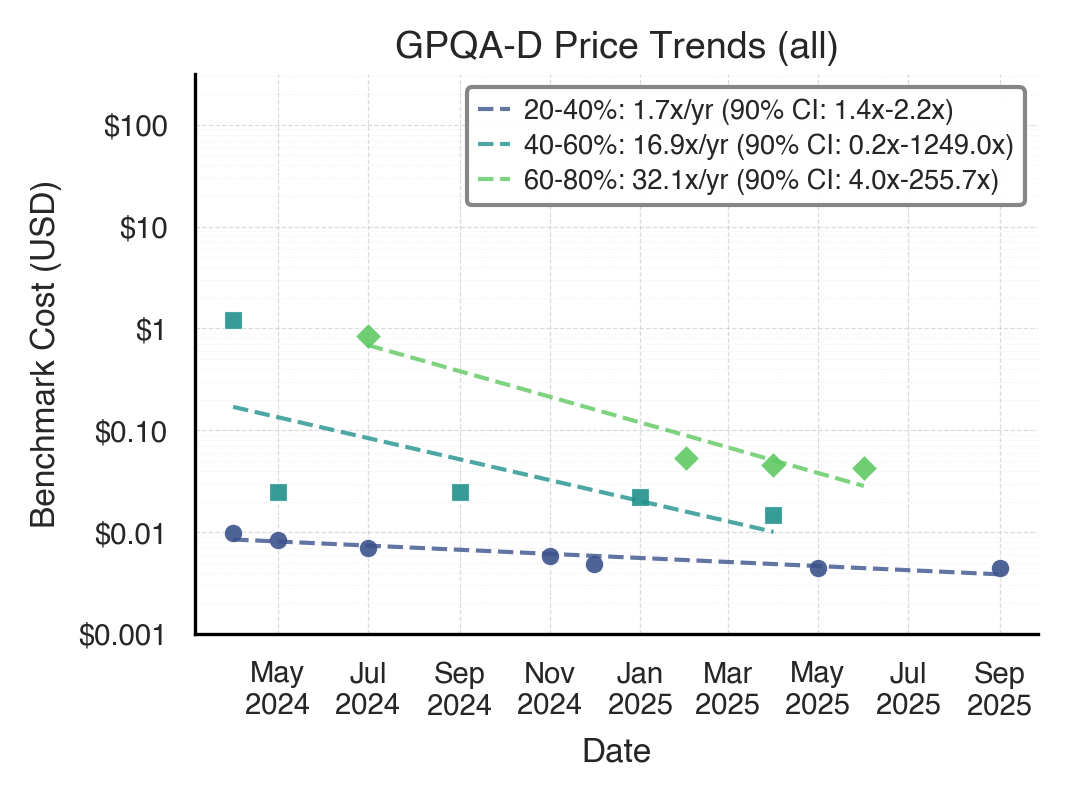

In [ ]:

plot_combined_record_small_trends(
    df,
    open_license_only=False,
    price_col="Benchmark Cost USD",
    confidence_interval=True,
    min_date=datetime(2024, 4, 1),
    benchmark_col='epoch_gpqa',
    show_model_names=False,
    include_reasoning_models=True,
    mmlu_ranges=[(20, 40), (40, 60), (60, 80)],
    date_granularity='day',  # change to 'month' to aggregate monthly before cummin
    save_path="figures/gpqa_all_license_bucket.png"  # Descriptive filename based on benchmark and license type
)


# Analysis of OTIS MOCK-AIME

MMLU 0-30% R² = 0.924
MMLU 30-60% R² = 0.953
MMLU 60-90% R² = 1.000
Figure saved to: figures/aime_open_license_bucket.png


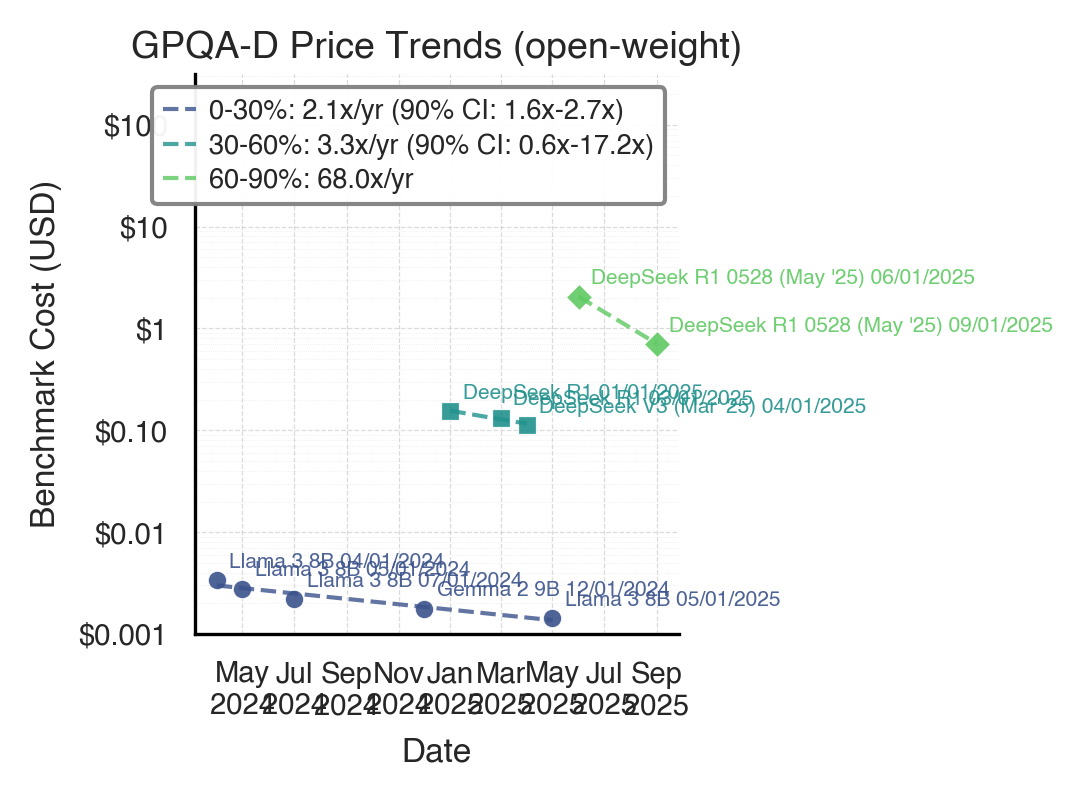

In [ ]:
df_aime = pd.read_csv('data/aime_price_reduction_models.csv')

#convert release date to datetime where release date is not nan
df_aime['Release Date'] = pd.to_datetime(df_aime['Release Date'])


# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df_aime['Active Parameters'] = np.where(
    df_aime['Known Active Parameters'].notna(),
    df_aime['Known Active Parameters'],
    df_aime['Parameters']
)

plot_combined_record_small_trends(
    df_aime,
    open_license_only=True,
    price_col="Benchmark Cost USD",
    confidence_interval=True,
    min_date=datetime(2024, 4, 1),
    benchmark_col='oneshot_AIME',
    show_model_names=True,
    include_reasoning_models=True,
    mmlu_ranges=[(0,30), (30, 60), (60, 90)],
    date_granularity='day',  # change to 'month' to aggregate monthly before cummin
    save_path="figures/aime_open_license_bucket.png"  # Descriptive filename based on benchmark and license type
)


# SWE-Bench if possible

MMLU 0-20% R² = 1.000
MMLU 20-40% R² = 1.000
MMLU 40-60% R² = 1.000
MMLU 60-80% R² = 1.000
Figure saved to: figures/swe_all_license_bucket.png


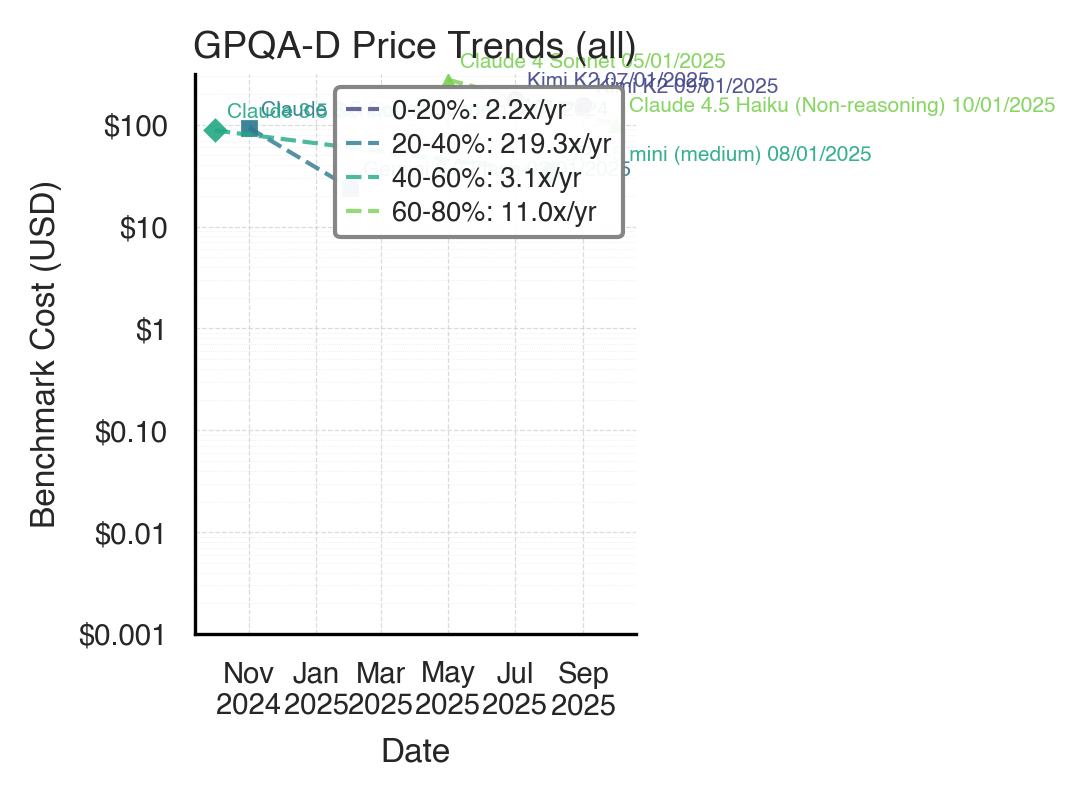

In [14]:
df_swe = pd.read_csv('data/swe_price_reduction_models.csv')

#convert release date to datetime where release date is not nan
df_swe['Release Date'] = pd.to_datetime(df_swe['Release Date'])


# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df_swe['Active Parameters'] = np.where(
    df_swe['Known Active Parameters'].notna(),
    df_swe['Known Active Parameters'],
    df_swe['Parameters']
)

plot_combined_record_small_trends(
    df_swe,
    open_license_only=False,
    price_col="Benchmark Cost USD",
    confidence_interval=True,
    min_date=datetime(2024, 4, 1),
    benchmark_col='epoch_swe',
    show_model_names=True,
    include_reasoning_models=True,
    mmlu_ranges=[(0, 20), (20, 40), (40, 60), (60, 80)],
    date_granularity='day',  # change to 'month' to aggregate monthly before cummin
    save_path="figures/swe_all_license_bucket.png"  # Descriptive filename based on benchmark and license type
)
